In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df=pd.read_csv('raw_with_170labels_version2.csv')
df.head()
duplicate_texts = df[df.duplicated(subset='text', keep=False)]

print(f"total {len(duplicate_texts)} duplicate_texts")
display(duplicate_texts.head(10))

total 0 duplicate_texts


,text,label


In [10]:
df.shape

(957, 2)

In [11]:
df_train = df.iloc[:170].copy()
df_test = df.iloc[170:].copy()
df_train.shape, df_test.shape

((170, 2), (787, 2))

In [12]:
df_train["label"].value_counts()

,count
label,
0.0,91
1.0,55
2.0,24


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import nltk
import spacy

nltk.download('stopwords')
from nltk.corpus import stopwords

nlp = spacy.load('en_core_web_sm')

df_train = df.iloc[:170].copy()
df_unlabeled = df.iloc[170:].copy()

def preprocess_text(text):
    text = text.lower()

    text = ''.join([char for char in text if char.isalpha() or char.isspace()])

    stop_words = set(stopwords.words('english'))
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text not in stop_words])

    return text

df_train['processed_text'] = df_train['text'].apply(preprocess_text)
df_unlabeled['processed_text'] = df_unlabeled['text'].apply(preprocess_text)

X = df_train['processed_text']
y = df_train['label']

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) 
X_tfidf = vectorizer.fit_transform(X)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

logreg = LogisticRegression(max_iter=1000)
svm = SVC(kernel='linear', random_state=42, probability=True)  # SVM with probability enabled

param_grid_logreg = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}
grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, n_jobs=-1)
grid_search_logreg.fit(X_resampled, y_resampled)
best_logreg = grid_search_logreg.best_estimator_

param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1)
grid_search_svm.fit(X_resampled, y_resampled)
best_svm = grid_search_svm.best_estimator_

voting_clf = VotingClassifier(estimators=[('logreg', best_logreg), ('svm', best_svm)], voting='soft')

voting_clf.fit(X_resampled, y_resampled)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

val_preds, val_true = [], []

for train_idx, val_idx in skf.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled[train_idx], X_resampled[val_idx]
    y_train, y_val = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    voting_clf.fit(X_train, y_train)
    preds = voting_clf.predict(X_val)

    val_preds.extend(preds)
    val_true.extend(y_val)

print(classification_report(val_true, val_preds, digits=4))

X_unlabeled_tfidf = vectorizer.transform(df_unlabeled['processed_text'])

probs = voting_clf.predict_proba(X_unlabeled_tfidf)  # shape: [n_samples, n_classes]

confidences = probs.max(axis=1)

preds = voting_clf.predict(X_unlabeled_tfidf)

df_unlabeled['pseudo_label'] = preds
df_unlabeled['confidence'] = confidences

print(df_unlabeled[['text', 'pseudo_label', 'confidence']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

         0.0     0.7925    0.9231    0.8528        91
         1.0     0.9103    0.7802    0.8402        91
         2.0     1.0000    0.9780    0.9889        91

    accuracy                         0.8938       273
   macro avg     0.9009    0.8938    0.8940       273
weighted avg     0.9009    0.8938    0.8940       273

                                                  text  pseudo_label  \
170  I’m 5 months pp with my second and I’m a singl...           1.0   
171  I've been really struggling this first week an...           1.0   
172  My SO intentionally missed work today to spend...           0.0   
173  Has anyone been hospitalised in a (mbu) mother...           1.0   
174  I’m almost 24 weeks postpartum and just really...           0.0   

     confidence  
170    0.432175  
171    0.840869  
172    0.463357  
173    0.562494  
174    0.483622  


In [41]:
high_conf_df = df_unlabeled[df_unlabeled['confidence'] >= 0.8]
low_conf_df = df_unlabeled[df_unlabeled['confidence'] <= 0.7]
print(f"\nNumber of pseudo-labeled samples with confidence greater than 0.8: {len(high_conf_df)} / {len(df_unlabeled)}")
print(f"\nNumber of pseudo-labeled samples with confidence less than or equal to 0.7: {len(low_conf_df)} / {len(df_unlabeled)}")


Number of pseudo-labeled samples with confidence greater than 0.8: 119 / 787

Number of pseudo-labeled samples with confidence less than or equal to 0.7: 526 / 787


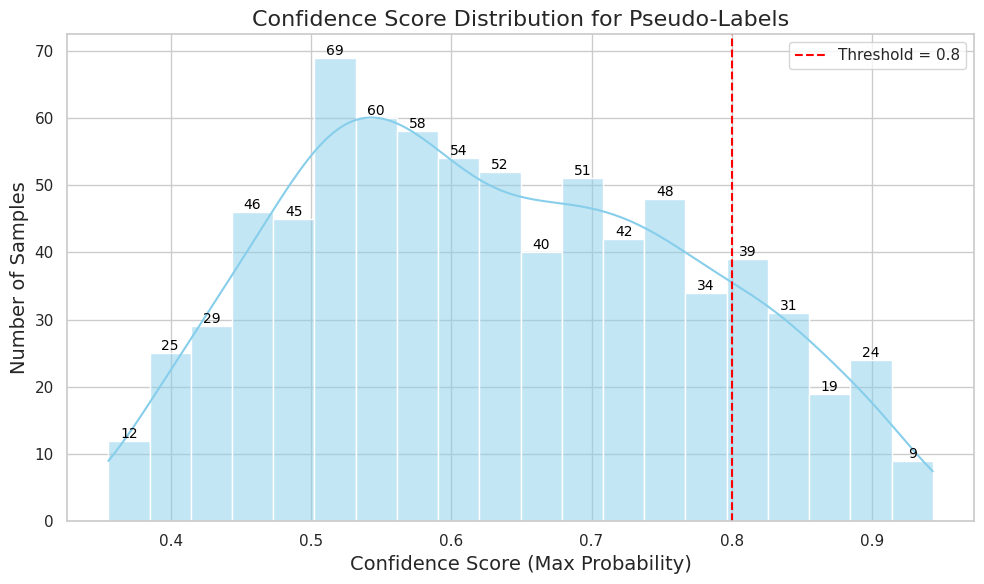

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))
ax = sns.histplot(df_unlabeled['confidence'], bins=20, kde=True, color='skyblue')

for p in ax.patches:
    height = p.get_height()  
    ax.text(p.get_x() + p.get_width() / 2, height, int(height),
            ha='center', va='bottom', fontsize=10, color='black')

plt.title('Confidence Score Distribution for Pseudo-Labels', fontsize=16)
plt.xlabel('Confidence Score (Max Probability)', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.axvline(0.8, color='red', linestyle='--', label='Threshold = 0.8')
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
df_unlabeled

,text,label,processed_text,pseudo_label,confidence
170,I’m 5 months pp with my second and I’m a singl...,NaN,month pp second single mom work minimum ho...,1.0,0.432175
171,I've been really struggling this first week an...,NaN,really struggle first week feel like need some...,1.0,0.840869
172,My SO intentionally missed work today to spend...,NaN,intentionally miss work today spend kid can no...,0.0,0.463357
173,Has anyone been hospitalised in a (mbu) mother...,NaN,anyone hospitalise mbu mother baby unit \n\n f...,1.0,0.562494
174,I’m almost 24 weeks postpartum and just really...,NaN,almost week postpartum really start feel ppd...,0.0,0.483622
...,...,...,...,...,...
952,"I hit 7 months postpartum tomorrow, and I thin...",NaN,hit month postpartum tomorrow think hit ever...,0.0,0.829803
953,PPD sucks. I’m overwhelmed by everything. Even...,NaN,ppd suck overwhelmed everything even med feel ...,0.0,0.452874
954,Hello! I’m a first time c section mom who’s 7 ...,NaN,hello first time c section mom week pp deal ...,0.0,0.714858
955,I finally reached breaking point today. I thin...,NaN,finally reach break point today think go try t...,0.0,0.850420


In [ ]:

df_high_confidence = df_unlabeled[df_unlabeled['confidence'] > 0.8]

high_conf_samples_count = df_high_confidence.shape[0]

print(f"Number of samples with confidence greater than 0.8: {high_conf_samples_count}")

df_high_confidence["pseudo_label"].value_counts()


Number of samples with confidence greater than 0.8: 119


,count
pseudo_label,
0.0,104
1.0,14
2.0,1


In [ ]:

print(df_high_confidence.index.to_list())


[171, 177, 186, 189, 191, 196, 200, 206, 208, 211, 217, 225, 227, 231, 235, 245, 246, 247, 252, 262, 266, 267, 275, 279, 281, 284, 299, 304, 318, 322, 329, 338, 344, 349, 354, 358, 359, 388, 389, 400, 406, 423, 449, 465, 473, 474, 476, 492, 503, 504, 513, 515, 521, 537, 538, 553, 559, 563, 564, 565, 570, 573, 576, 578, 584, 586, 592, 593, 612, 633, 634, 635, 641, 653, 656, 675, 680, 700, 713, 718, 719, 726, 727, 733, 736, 740, 744, 747, 760, 765, 777, 785, 799, 802, 804, 811, 814, 815, 829, 832, 835, 840, 841, 852, 858, 864, 871, 872, 901, 906, 919, 925, 933, 938, 939, 940, 945, 952, 955]


In [ ]:
df_low_confidence = df_unlabeled[df_unlabeled['confidence'] < 0.5]

low_conf_samples_count = df_low_confidence.shape[0]

df_low_confidence["pseudo_label"].value_counts()


,count
pseudo_label,
1.0,70
0.0,60
2.0,23


In [ ]:

df_unlabeled.to_csv('df_unlabeled.csv', index=True)


In [50]:
df_high_confidence.to_csv('df_high_confidence.csv', index=True)